In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum, auto
from scipy.spatial import distance


from binit.align import align_around
from observational_fear import load
from observational_fear.events import get_block_starts
from neurobox.wide_transforms import resample
from sklearn.decomposition import PCA
sns.set_style("whitegrid")


class TrajectoryFinder:    
    def get_scree(self, X):
        res = (1- PCA().fit(X).explained_variance_ratio_) * 100
        return pd.DataFrame({"num_pcs": np.arange(1, len(res) + 1), "pct_var": res}) 
    
    def get_trajectories(self, X, num_pcs):
        df =  pd.DataFrame(PCA(2).fit_transform(X), columns=[f"PC{i}" for i in range(1, num_pcs + 1)])
        df["time"] = X.index
        df.index = X.index
        df = self._centroid_distances(df)
        return df
    
    @staticmethod
    def _centroid_distances(df):
        centroid_pre = df.loc[df.index < 0].mean().values
        centroid_post = df.loc[df.index >=0].mean().values
        
        d_pre = df.bfill().apply(lambda x: distance.euclidean(x.values, centroid_pre), axis=1)
        d_post = df.bfill().apply(lambda x: distance.euclidean(x.values, centroid_post), axis=1)
        df_distance = pd.DataFrame({"d_centroid_pre": d_pre, "d_centroid_post":d_post})

        return pd.concat([df, df_distance], axis=1)

    def get_prepost_scree(self, X, max_pcs=20):
        df_pre = (
            self.get_scree(X.loc[X.index < 0])
            .assign(segment="pre")
            .sort_values("num_pcs")
            .iloc[:max_pcs]
        )
        df_post = (
            self.get_scree(X.loc[X.index >= 0])
            .assign(segment="post")
            .sort_values("num_pcs")
            .iloc[:max_pcs]
        )
        return (
            pd.concat([df_pre, df_post])
            .pivot(index="num_pcs", columns="segment", values="pct_var")
            .reset_index()
            .rename_axis(None, axis=1)
        )
    


def psth(df, events, t_before=5, t_after=5):
    df = df.reset_index().melt(id_vars=["time"])
    return (
        df
        .assign(
            aligned=lambda x: np.round(
                align_around(x["time"].values, events, t_before=t_before, max_latency=t_after), 2
            )
        )
        .pivot_table(columns="new_id", values="value", index="aligned")
        .apply(zscore)
    )

def get_freeze_trajectory_results(X, n_pcs):
    out = {}
    decomposer = TrajectoryFinder()
    out["scree"] = decomposer.get_scree(X)
    out["prepost_scree"] = decomposer.get_prepost_scree(X)
    out["trajectories"] = decomposer.get_trajectories(X, n_pcs)
    return out

def load_block_data(data_dir, session, block, time_interval="100ms", coreg_only=True):
    df = load.load_traces(data_dir, session=session)
    if coreg_only:
        cells = load.load_block_coreg_cells(data_dir)
        df = df[["time"] + cells.tolist()]
    df = resample(df.set_index("time"), time_interval)
    events = get_block_starts(session=session, block_name=block)
    return df, events


def get_block_trajectory_results(df, events, t_before=5, t_after=5, n_pcs=2):
    out = {}
    X = psth(df, events, t_before=t_before, t_after=t_after)
    decomposer = TrajectoryFinder()
    out["scree"] = decomposer.get_scree(X)
    out["prepost_scree"] = decomposer.get_prepost_scree(X)
    out["trajectories"] = decomposer.get_trajectories(X, n_pcs)
    return out


class TrajectoryResultSaver:

    def __init__(self, data_dir: Path, fname: str, results: dict):
        self.data_dir = data_dir
        self.fname = fname
        self.results = results
    
    def save(self):
        self._save_scree()
        self._save_trajectories()
        self._save_prepost_scree()
        self._save_scree_fig()
        self._save_prepost_scree_fig()
    
    def _save_scree(self):
        df = self.results["scree"]
        df.to_csv(self.data_dir / f"{self.fname}_scree.csv", index=False)
    
    def _save_trajectories(self, ):
        df = self.results["trajectories"]
        df.to_csv(self.data_dir / f"{self.fname}_trajectories.csv", index=False)
    
    def _save_prepost_scree(self):
        df = self.results["prepost_scree"]
        df.to_csv(self.data_dir / f"{self.fname}_prepost_scree.csv", index=False)
    
    def _save_scree_fig(self):
        _, ax = plt.subplots()
        results["scree"].plot(x="num_pcs", y="pct_var", ax=ax)
        ax.set_title(f"{self.fname} Scree Plot")
        ax.set_ylabel("% Variation Retained")
        plt.savefig(self.data_dir / f"{self.fname}_scree_plot.svg")
        
    def _save_prepost_scree_fig(self,):
        _, ax = plt.subplots()
        results["prepost_scree"].plot(x="num_pcs", y="pre", ax=ax)
        results["prepost_scree"].plot(x="num_pcs", y="post", ax=ax)
        ax.set_title(f"{self.fname} Pre-Post Scree Plot")
        ax.set_ylabel("% Variation Retained")
        plt.savefig(self.data_dir / f"{self.fname}_prepost_scree_plot.svg")



DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
derived_dir = DATA_DIR / "derived"
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")


In [2]:
dfd2, events = load_block_data(
    data_dir=DATA_DIR, session="day2", block="US", coreg_only=True
)
results = get_block_trajectory_results(dfd2, events, t_before=5, t_after=5)
# saver = TrajectoryResultSaver(data_dir=derived_dir, fname="US_day2", results=results)
# saver.save()

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


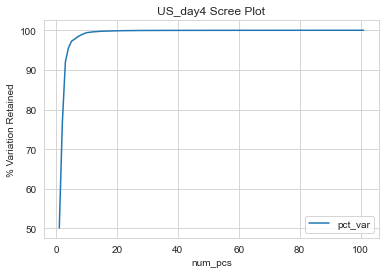

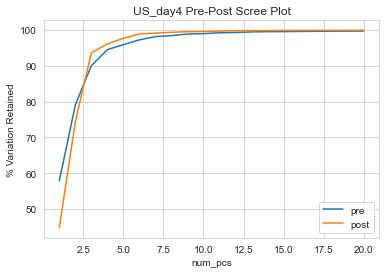

In [15]:
dfd4, events = load_block_data(
    data_dir=DATA_DIR, session="day4", block="US", coreg_only=True
)
results = get_block_trajectory_results(dfd4, events, t_before=5, t_after=5)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname="US_day4", results=results)
saver.save()

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


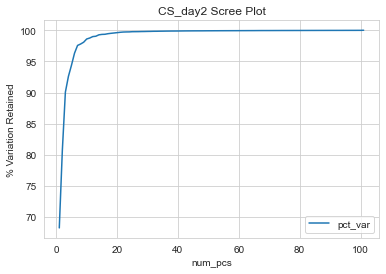

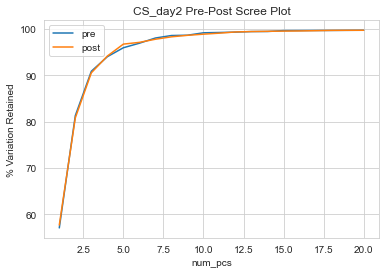

In [16]:
dfd2, events = load_block_data(
    data_dir=DATA_DIR, session="day2", block="CS", coreg_only=True
)
results = get_block_trajectory_results(dfd2, events, t_before=5, t_after=5)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname="CS_day2", results=results)
saver.save()

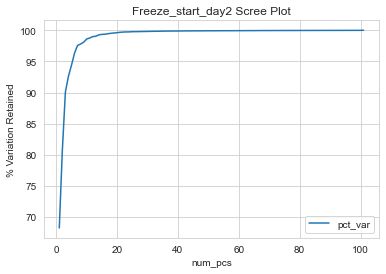

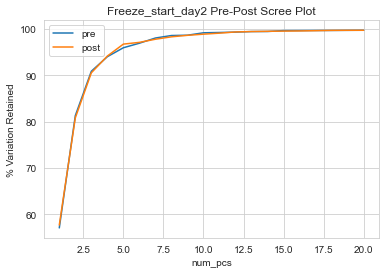

In [17]:
session="day2"
start_stop="start"

df = (
    load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)

res = get_freeze_trajectory_results(df, n_pcs=2)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname=f"Freeze_{start_stop}_{session}", results=results)
saver.save()

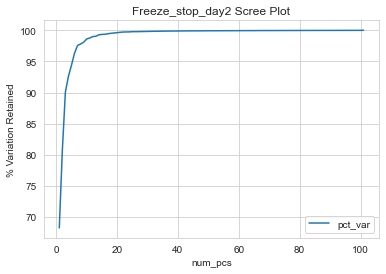

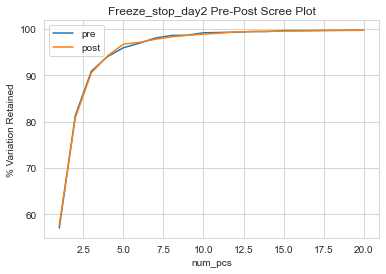

In [18]:
session="day2"
start_stop="stop"

df = (
    load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)

res = get_freeze_trajectory_results(df, n_pcs=2)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname=f"Freeze_{start_stop}_{session}", results=results)
saver.save()

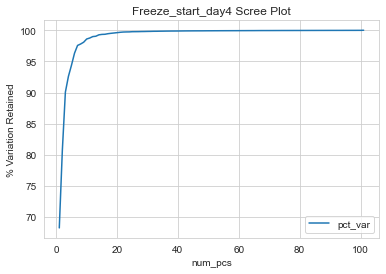

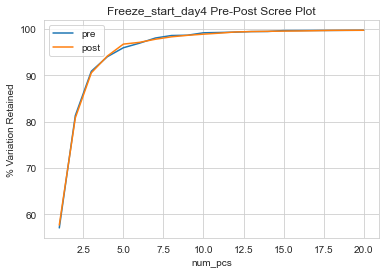

In [20]:
session="day4"
start_stop="start"

df = (
    load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)

res = get_freeze_trajectory_results(df, n_pcs=2)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname=f"Freeze_{start_stop}_{session}", results=results)
saver.save()

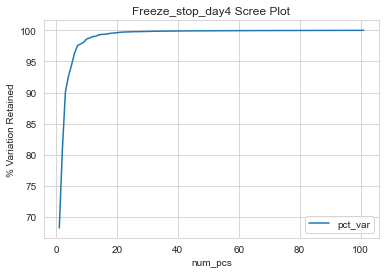

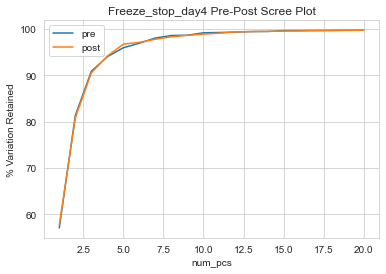

In [21]:
session="day4"
start_stop="stop"

df = (
    load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)

res = get_freeze_trajectory_results(df, n_pcs=2)
saver = TrajectoryResultSaver(data_dir=derived_dir, fname=f"Freeze_{start_stop}_{session}", results=results)
saver.save()